<a href="https://colab.research.google.com/github/gustavoravel/data_science_portfolio/blob/main/M%C3%A9todo_Box_Jenkins_para_previs%C3%A3o_de_s%C3%A9ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Método Box-Jenkins para previsão de séries temporais.

O futuro é algo que causa uma certa inquietação na maioria das pessoas. Por isso há muito tempo deseja-se prever o que vai acontecer.

Sabemos que isso é impossível, pois não há como saber o que ainda não se viveu... Felizmente, o mais próximo que a ciência conseguiu chegar de antecipar acontecimentos futuros foi através de projeções baseados em dados estatísticos (vide previsão do tempo), e estudo de repetições de acontecimentos no passado que voltam a ocorrer de tempos em tempos.

<center><img alt="Colaboratory logo" width="50%" src="https://www.meioemensagem.com.br/wp-content/uploads/2019/01/predicting-tech-future-670x335.jpg"></center>

Hoje em dia, a ciência de dados conta com ferramentas que auxiliam nesses estudos, como a análise de tendências, sazonalidades, ciclicidades etc. E vários campos de negócios se beneficiam desses estudos, como a política, finanças, tecnologia, tentando prever o comportamento de seu público nos próximos dias, meses, anos.

Neste artigo vou demonstrar como um modelo de análise de série temporal pode ser criado, fazer identificações e estimações para ir à produção, utilizando os dados da Microsoft na bolsa através do framework Box-Jenkins.

## Framework Box-Jenkins

Método nomeado pelos estatísticos George Box e Gwilym Jenkins, consiste em utilizar uma aproximação à análise de dados temporais baseada em 3 estágios:



*   Identificação e Seleção do Modelo
      
      Nesse estágio os dados são graficamente computados para verificar se há alguma sazonalidade e achar o período sazonal, para assim transformá-los em dados estacionários.

*   Estimativa dos Parâmetros

      Nesse estágio ocorre a escolha do modelo, imputação dos dados e análise dos parâmetros de previsão, valores de autoregressão, média móvel, integração (ARIMA, na maioria das vezes), regressão linear etc.

*   Diagnóstico do Modelo

      Nesse estágio são analizados os residuais (valor real - valor previsto), média, variância e coeficientes e plotagens de autocorrelação e autocorrelação parcial. Se a estimativa for inadequada, um estágio deve ser regredido. Caso contrário, o modelo vai para produção.

O melhor é mostrado por exemplo:

In [1]:
#importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.style.use('seaborn-darkgrid')

In [2]:
#atualizar pacote statsmodels no google colab
#!pip install --upgrade statsmodels 

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
#obtenção dos dados
df = pd.read_csv('Microsoft_Stock.csv', index_col='Date', parse_dates=True, dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-01-04 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [5]:
#organização do dataset
df.index = df.index.normalize()
df = df.sort_index()
df.head(7)

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-04,40.60,40.76,40.31,40.72,36865322
2015-01-05,48.58,48.88,48.40,48.66,38937336
2015-01-06,47.06,47.77,46.62,47.23,28837332
2015-01-07,44.49,45.23,44.10,44.45,28343907
2015-01-09,42.17,42.59,41.66,41.82,49688896
2015-01-10,44.75,44.75,43.75,44.61,28657859
2015-01-12,54.41,55.23,54.30,55.22,39952779


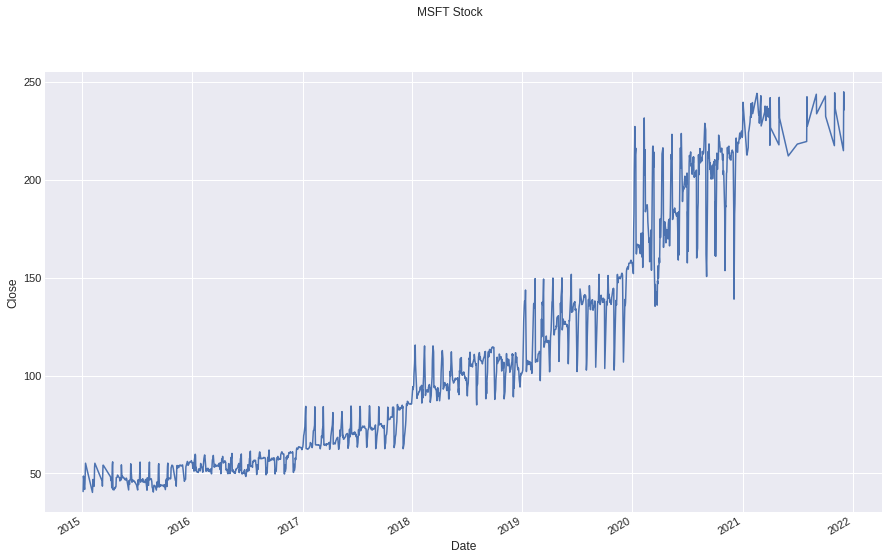

In [6]:
#visualização dos dados
ax = df['Close'].plot(subplots=True, 
                      figsize=(15,9),
                      title='MSFT Stock',
                      xlabel='Date',
                      ylabel='Close'
                      )
plt.show()

No gráfico acima, vemos a evolução do fechamento do preço da ação da Microsoft em dólar, no período de 04 de Janeiro de 2015 à 31 de Março de 2021. Um período longo o suficiente para notarmos padrões de sazonalidade, tendência e volatilidade e um leve ruído na época da pandemia (2020 - 2021).



## 1 - Identificação e Seleção do Modelo

E aqui está o primeiro desafio do nosso framework: tornar nossa série temporal estacionária. Mas afinal de contas, o que seria uma série temporal estacionária?

De acordo com o Oxford Languages, estacionário é o que se mantém no mesmo lugar; imóvel, parado, estacional. Dentro da estatística, uma estacionariedade quer dizer que toda a distribuição de dados é invariável no tempo, diferente da não estacionariedade, em que a média, variância e autocorrelação é invariável no tempo. Ou seja, se esses parâmetros variam com o tempo, são muitos parâmetros para estimar.

A solução aqui é aplicar uma transformação. Basicamente implica em comparar o valor do dia atual, com o valor do dia anterior (diferença, mudança percentual, logarítmo etc.), assim será produzida uma nova série, de onde partiremos nossas análises:

In [7]:
#tirando a diferença
df_stationary = df.diff().dropna()
df_stationary = df_stationary.asfreq('D').dropna()
df_stationary.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-05,7.98,8.12,8.09,7.94,2072014.0
2015-01-06,-1.52,-1.11,-1.78,-1.43,-10100004.0
2015-01-07,-2.57,-2.54,-2.52,-2.78,-493425.0
2015-01-09,-2.32,-2.64,-2.44,-2.63,21344989.0
2015-01-10,2.58,2.16,2.09,2.79,-21031037.0


In [8]:
df_stationary.describe()

,Open,High,Low,Close,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,0.128086,0.129179,0.127762,0.129159,-9.411695e+03
std,8.202055,8.075323,8.218488,8.302622,1.440812e+07
min,-67.110000,-66.480000,-72.920000,-63.440000,-9.360714e+07
25%,-0.940000,-0.800000,-0.847500,-1.005000,-6.074078e+06
50%,0.230000,0.205000,0.250000,0.230000,-3.924460e+05
75%,2.117500,1.960000,2.000000,2.132500,5.891143e+06
max,41.500000,37.490000,43.720000,43.450000,1.044742e+08


Note que ao tirar a diferença, colocamos os valores dentro de uma escala de distribuição menos variável, facilitando o entendimento da temporalidade e resumindo seu acontecimento, basicamente: 

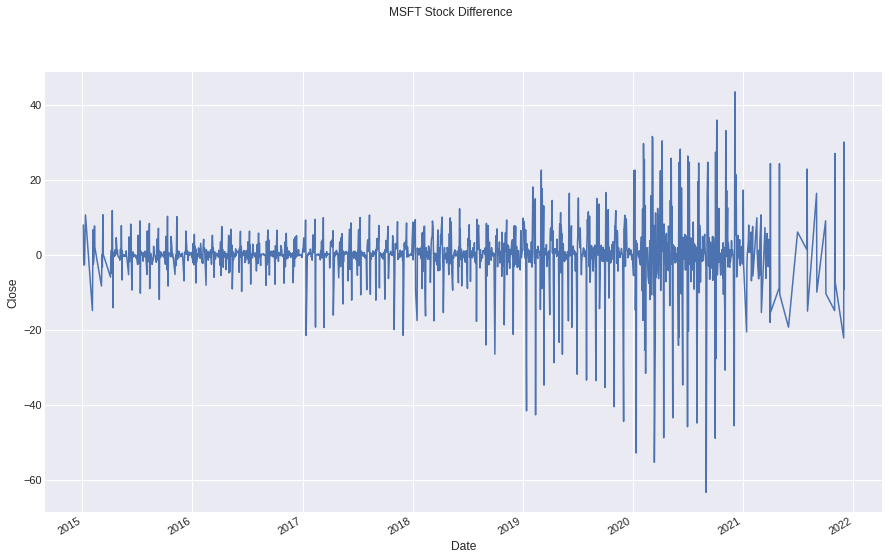

In [9]:
#visualização dos dados estacionários
ax = df_stationary['Close'].plot(subplots=True, 
                      figsize=(15,9),
                      title='MSFT Stock Difference',
                      xlabel='Date',
                      ylabel='Close'
                      )
plt.show()

Comparando a nova série diferenciada com o valor real, notamos através do Teste de Dickey-Fuller aumentado (sugerido em 1979 pelos estatísticos Dickey e Fuller), notamos que ela se tornou estacionária, quanto mais negativo o resultado do teste ADF, maior a probabilidade da série ser estacionária.

In [10]:
results = adfuller(df['Close'])
results

(1.7196112874521354,
 0.9981755108097898,
 24,
 1486,
 {'1%': -3.4347582315402434,
  '10%': -2.567806534528638,
  '5%': -2.863486949792871},
 10109.631664236022)

In [11]:
results2 = adfuller(df_stationary['Close'])
results2

(-11.685947218979898,
 1.697063579755839e-21,
 24,
 1485,
 {'1%': -3.43476120520139,
  '10%': -2.567807233388883,
  '5%': -2.863488262178673},
 10100.40486479117)

Agora que temos os dados estacionários, precisamos saber quais os lags (quantidade de passos dados para trás) de autoregressão e média móvel serão os mais promissores.

Fazemos isso através da autocorrelação e da autocorrelação parcial (medida de quanto o valor do dia atual está correlacionado com o valor dos dias anteriores em uma certa quantidade de lags, e parcialmente, removendo os efeitos dos lags anteriores).

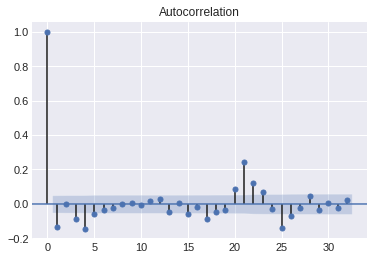

In [12]:
plot_acf(df_stationary['Close'])
plt.show()

Note que computada a autocorrelação na série estacionária, há uma reversão média, os valores de correlação se alternam fora de ordem, indicando uma correlação negativa. Nesses casos, os melhores parâmetros para a estimativa do nosso modelo de previsão são aqueles baseados em média móvel.

Como comparação, veja a diferença ao computar a autocorrelação na série original:

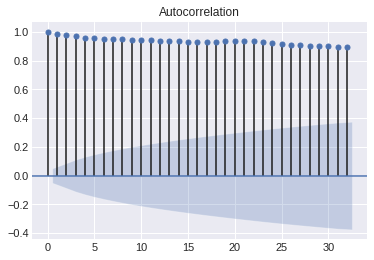

In [13]:
plot_acf(df['Close'])
plt.show()

Os valores de autocorrelação estão organizados em momentum, ou uma tendência de seguimento, indicando assim uma autocorrelação positiva. Caso nossa série estacionária apresentasse um comportamento similar, os melhores parâmetros para a estimativa do nosso modelo de previsão seriam aqueles baseados em autorregressão.

Nesse exemplo das ações da Microsoft em específico, é um comportamento comum ações individuais possuírem uma correlação negativa, por isso eles são medidos em horizontes curtos (questão de dias).

## 2 - Estimativa dos Parâmetros

Agora que concluímos nosso primeiro estágio, podemos usar os dados para treinar os coeficientes dos nossos modelos de machine learning.

Nesse caso já temos uma configuração interessante para fazer nossas estimativas batizado de ARIMA (do inglês AutoRegressive Integrated Moving Average).

O segredo aqui é treinar o mesmo modelo com parâmetros de autorregressão e média móvel diferentes (a ordem de integração automaticamente será 1, haja visto termos realizado uma diferenciação para tornar a série estacionária) e comparar os modelos usando AIC (Akaike Information Criteria) e BIC (Bayesian Information Criteria), dois critérios de informação estatística que auxiliam na escolha de modelos com base nas ordens e previsões realizadas. 

In [14]:
#reorganização do dataset (para preservar as datas do index) 
df_stationary = df_stationary.asfreq('D', method='ffill')
#separação entre treino e teste
df_train = df_stationary.loc[:'2019']
df_test = df_stationary.loc['2020':]

In [ ]:
#pesquisando entre AIC e BIC
order_aic_bic = []
#loop entre ordens de autoregressão
for p in range(3):
  #loop entre ordens de média móvel
  for q in range(3):
    #fit do modelo
    model = ARIMA(df_train['Close'], order=(p, 1, q), exog=df_train.drop('Close', axis=1))
    results = model.fit()
    #adiciona ordem e placares para a lista
    order_aic_bic.append((p, q, results.aic, results.bic))

#dataframe contendo as ordens e placares AIC/BIC
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

Após treinados os modelos, podemos comparar seus placares e ordens e analizar os critérios de escolha.

In [16]:
#ordenar por AIC
print(order_df.sort_values('aic'))

   p  q           aic           bic
2  0  2   3481.363965   3519.913953
5  1  2   3534.122942   3578.180071
4  1  1   3645.425933   3683.975920
1  0  1   3731.395004   3764.437850
6  2  0   4025.244314   4063.794301
3  1  0   4189.106782   4222.149628
8  2  2   4978.234667   5027.798936
7  2  1   6167.696672   6211.753801
0  0  0  16467.375439  16494.911144


Um valor de AIC mais baixo indica um modelo melhor

In [17]:
#ordenar por BIC
print(order_df.sort_values('bic'))

   p  q           aic           bic
2  0  2   3481.363965   3519.913953
5  1  2   3534.122942   3578.180071
4  1  1   3645.425933   3683.975920
1  0  1   3731.395004   3764.437850
6  2  0   4025.244314   4063.794301
3  1  0   4189.106782   4222.149628
8  2  2   4978.234667   5027.798936
7  2  1   6167.696672   6211.753801
0  0  0  16467.375439  16494.911144


Bem parecido a AIC, BIC baixo também indica um bom modelo, porém BIC gosta de escolher modelos simples e de ordem inferior.


## 3 - Diagnóstico do Modelo

Nesse estágio, analizamos a correlação entre os valores residuais (valor real - valor previsto) e sua distribuição, plotando um histograma para visualizar sua forma. Se os residuais estiverem normalmente distribuídos, apresentando uma curva Gaussiana (formato de sino) significa que o modelo se encaixa bem aos dados e pode-se começar os testes para enviá-lo à produção.

Após ordenar or modelos, vemos que o modelo com o melhor placar nos dois critérios de informação é o que possui ar=0 e ma=2 (nenhum lag de autoregressão e 2 lags de média móvel). Vamos analizar os diagnósticos e os residuais desse modelo:

In [18]:
model = ARIMA(df_train['Close'], order=(0, 1, 2), exog=df_train.drop('Close', axis=1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1822
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1733.682
Date:                Tue, 31 Aug 2021   AIC                           3481.364
Time:                        23:36:05   BIC                           3519.914
Sample:                    01-05-2015   HQIC                          3495.586
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.6217      0.012    -50.690      0.000      -0.646      -0.598
High           0.8324      0.015     57.176      0.000       0.804       0.861
Low            0.7874      0.013     60.881      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


No Resumo do modelo, vemos os resultados estatísticos para várias hipóteses, porém vamos focar em apenas alguns, na segunda parte do resumo:



*   Variáveis (linhas):
    
      Aqui são apresentadas as variáveis presente no dataset, a ordem dos lags de média móvel e autorregressão e variância ao quadrado (erro da previsão)
*   Resultados dos testes (colunas)

      Aqui temos os fatores coeficientes, erro padrão e p-values (evidência contra hipótese nula). Se estes valores estiverem muito altos, a variável em si precisa ser revisada, no caso do coeficiente, quanto maior, mais importante ele é para a previsão, no caso dos p-values, quanto menor, mais evidência contra hipótese nula. 



In [19]:
#erro médio absoluto (mae)
residuals = res.resid
mae = np.mean(np.abs(residuals))
print(mae)

0.43583737288395036


Já o erro médio absoluto (mean squared error) expressa precisão como uma porcentagem do erro, indicando que nosso modelo tem 57% de precisão. Dependendo da aplicação, esse modelo não poderia subir para produção. Continuaremos com ele de forma didática.

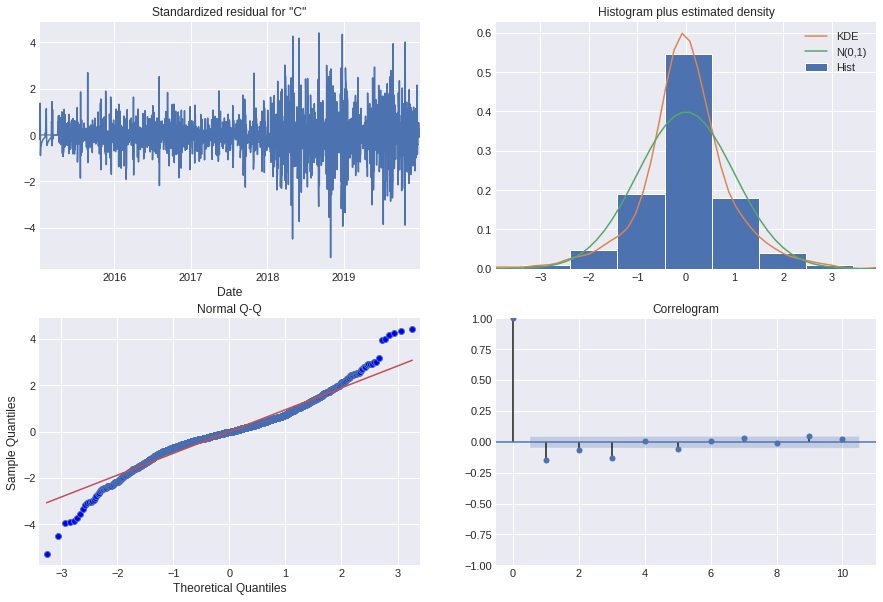

In [20]:
res.plot_diagnostics(figsize=(15, 10))
plt.show()

Resíduos padronizados: basicamente é feita uma padronização no z-score (o quanto ele está longe do desvio padrão) dos residuais para medir a diferença entre os valores observados e esperados, e se estão contribuindo mais e quais estão contribuindo menos.

No histograma, conseguimos verificar os resíduos normalmente distribuídos.

## Produção

Digamos que nosso modelo passou nos testes e agora precisa fazer previsões. Para isso utilizaremos a função de forecast do próprio modelo.

In [21]:
#forecast com o modelo
forecast = res.get_forecast(steps=30, exog=df_train.drop('Close', axis=1)[-30:])
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.columns[0] 
upper_limits = confidence_intervals.columns[1]

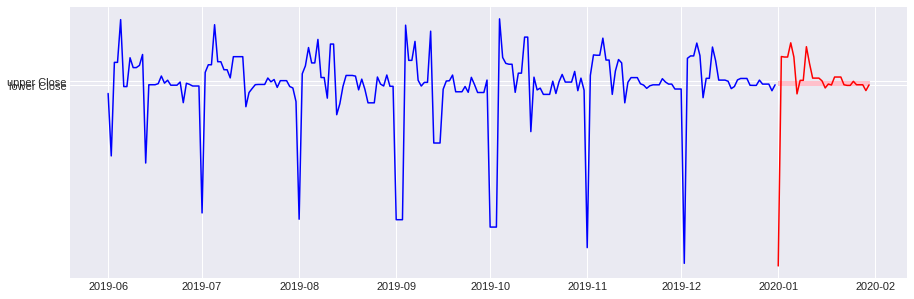

In [22]:
plt.figure(figsize=(15, 5))

#dados reais estacionários a partir de junho de 2019
plt.plot(df_train.loc['2019-06':].index, df_train['Close'].loc['2019-06':], color='blue')
#forecast
plt.plot(mean_forecast.index, mean_forecast.values, color='red')
#intervalo de confiança
plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

plt.show()

Dessa forma vemos como nosso modelo tenta prever o comportament dos próximos dias na bolsa, com um intervalo bem estreito de precisão. Obviamente ainda há muita calibragem a se fazer, note que anteriormente os dados foram separados entre treino e teste, e outros valores tiveram de ser mockados para o funcionamento total do modelo.



## Conclusão

Uma certeza que temos a respeito do futuro é que: prever o futuro ainda será uma obsessão do ser humano, e para isso ele irá recorrer aos mais variados métodos existentes. Mas no mundo dos negócios não podemos simplesmente jogar tudo ao acaso. Antecipar acontecimentos sempre será uma ótima alternativa, se os melhores dados estiverem ao nosso alcance!

Gustavo Soares via [Deneb AI](https://denebdata.com)